# Employee Burnout Analysis
### --> by Nandini Yadav

##Importing Libraries

In [2]:
#Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import joblib

## Load dataset

In [3]:
# Load dataset
data = pd.read_csv('/content/employee_burnout.csv')

## Explore data

In [4]:
# Explore data
print("Data Preview:")
print(data.head())
print("\nSummary:\n", data.info())

Data Preview:
                Employee ID Date of Joining  Gender Company Type  \
0  fffe32003000360033003200      2008-09-30  Female      Service   
1      fffe3700360033003500      2008-11-30    Male      Service   
2  fffe31003300320037003900      2008-03-10  Female      Product   
3  fffe32003400380032003900      2008-11-03    Male      Service   
4  fffe31003900340031003600      2008-07-24  Female      Service   

  WFH Setup Available  Designation  Resource Allocation  Mental Fatigue Score  \
0                  No            2                  3.0                   3.8   
1                 Yes            1                  2.0                   5.0   
2                 Yes            2                  NaN                   5.8   
3                 Yes            1                  1.0                   2.6   
4                  No            3                  7.0                   6.9   

   Burn Rate  
0       0.16  
1       0.36  
2       0.49  
3       0.20  
4       0.52  


## Handle missing values

In [6]:
# Handle missing values
data.fillna(data.median(numeric_only=True), inplace=True)

## Encoding categorical variables

In [7]:
# Encoding categorical variables
le = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

## Feature Selection

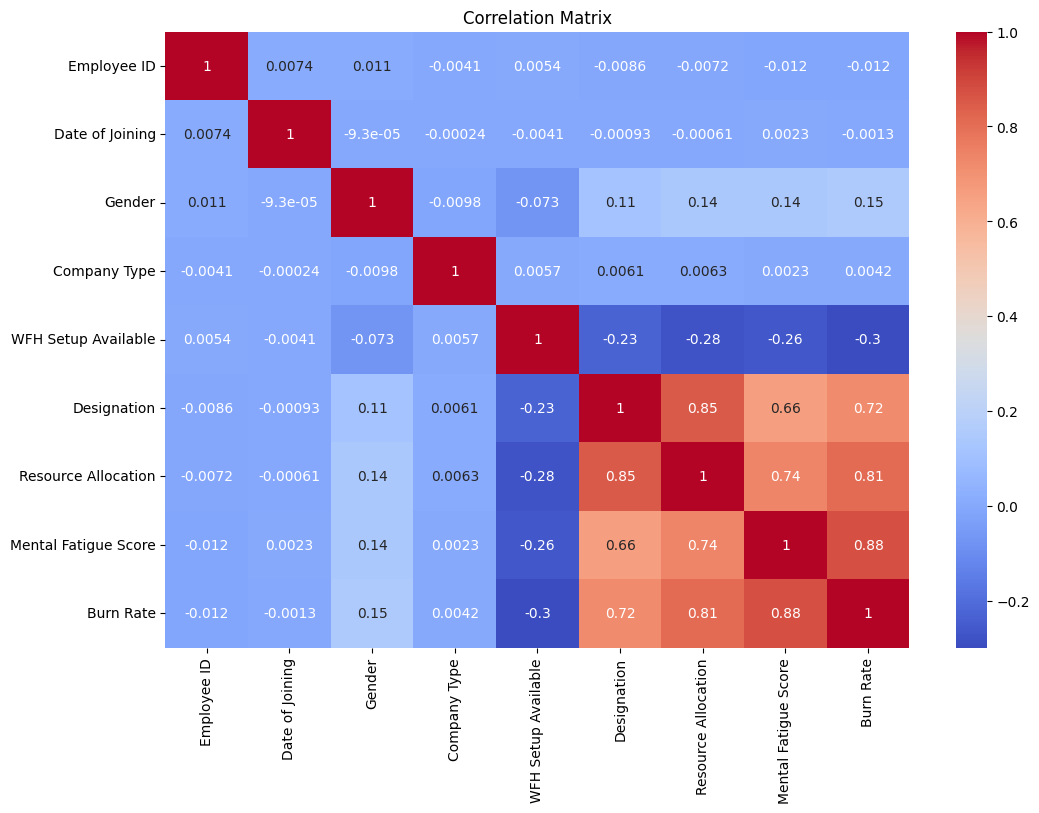

In [8]:
# Feature Selection
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Selecting top features based on correlation

In [12]:
# Selecting top features based on correlation
# Verify 'Burnout' exists
if 'Burn Rate' in correlation_matrix.columns:
    correlation_threshold = 0.2
    selected_features = correlation_matrix['Burn Rate'].abs().sort_values(ascending=False)
    selected_features = selected_features[selected_features > correlation_threshold].index
    print(f"Selected Features: {list(selected_features)}")
else:
    print("'Burnout' is not found in the correlation matrix. Check the dataset or column name.")


Selected Features: ['Burn Rate', 'Mental Fatigue Score', 'Resource Allocation', 'Designation', 'WFH Setup Available']


## Splitting data

In [13]:
# Splitting data
X = data[selected_features].drop('Burn Rate', axis=1)
y = data['Burn Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Standardizing Data

In [14]:
# Standardizing Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Models

In [15]:
# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

## Train and Evaluate

In [17]:
# Convert continuous target to binary classification if needed
if y_train.dtype != 'int' and y_train.dtype != 'bool':
    threshold = y_train.median()  # Define threshold for binary classification
    y_train = (y_train > threshold).astype(int)
    y_test = (y_test > threshold).astype(int)

# Ensure target is discrete
print(f"Unique values in y_train: {y_train.unique()}")
print(f"Unique values in y_test: {y_test.unique()}")

# Train and evaluate models
model_results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc}")

    # Save results
    model_results[model_name] = {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

    # Save model
    joblib.dump(model, f"{model_name.replace(' ', '_').lower()}_burnout_model.pkl")

Unique values in y_train: [1 0]
Unique values in y_test: [0 1]
Training Logistic Regression...

Logistic Regression Evaluation Metrics:
Accuracy: 0.8818
Precision: 0.8829
Recall: 0.8622
F1 Score: 0.8724
AUC: 0.9496873315499818
Training Decision Tree...

Decision Tree Evaluation Metrics:
Accuracy: 0.8769
Precision: 0.8827
Recall: 0.8504
F1 Score: 0.8663
AUC: 0.9459214219640106
Training Random Forest...

Random Forest Evaluation Metrics:
Accuracy: 0.8793
Precision: 0.8789
Recall: 0.8612
F1 Score: 0.8700
AUC: 0.9488496761007407
Training Support Vector Machine...

Support Vector Machine Evaluation Metrics:
Accuracy: 0.8862
Precision: 0.8854
Recall: 0.8697
F1 Score: 0.8775
AUC: 0.9403242503434707
Training Gradient Boosting...

Gradient Boosting Evaluation Metrics:
Accuracy: 0.8846
Precision: 0.8825
Recall: 0.8697
F1 Score: 0.8760
AUC: 0.9528773469530659
Training XGBoost...

XGBoost Evaluation Metrics:
Accuracy: 0.8855
Precision: 0.8886
Recall: 0.8640
F1 Score: 0.8762
AUC: 0.9526374072076191

## Model Comparison

In [18]:
# Model Comparison
result_df = pd.DataFrame(model_results).T
print("\nModel Comparison:")
print(result_df)


Model Comparison:
                        Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression     0.881758   0.882861  0.862166  0.872391  0.949687
Decision Tree           0.876923   0.882725  0.850445  0.866285  0.945921
Random Forest           0.879341   0.878947  0.861228  0.869998  0.948850
Support Vector Machine  0.886154   0.885442  0.869667  0.877483  0.940324
Gradient Boosting       0.884615   0.882493  0.869667  0.876033  0.952877
XGBoost                 0.885495   0.888621  0.864041  0.876159  0.952637


## Visualize Results

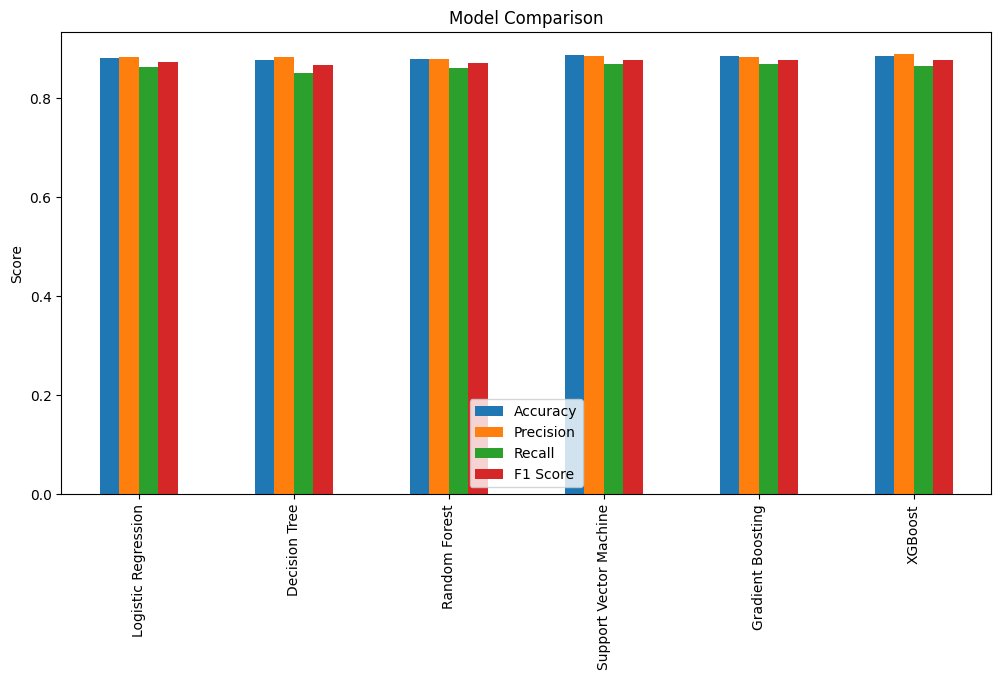

In [19]:
# Visualize Results
result_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.show()

## Hyperparameter Tuning for Random Forest

In [20]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', verbose=2)
grid_search.fit(X_train, y_train)

print("\nBest Parameters for Random Forest:", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, 

## Re-train with best parameters

In [21]:
# Re-train with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)
y_pred_rf = best_rf_model.predict(X_test)
print("\nFinal Random Forest Evaluation Metrics:")
print(classification_report(y_test, y_pred_rf))


Final Random Forest Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2417
           1       0.88      0.86      0.87      2133

    accuracy                           0.88      4550
   macro avg       0.88      0.88      0.88      4550
weighted avg       0.88      0.88      0.88      4550



# Final model

In [27]:
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the best model and scaler
best_rf_model = joblib.load('best_random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')  # Load the scaler you used during training

# User-friendly prediction
def predict_burnout(input_data):
    model = joblib.load('best_random_forest_model.pkl')
    input_scaled = scaler.transform(np.array(input_data).reshape(1, -1))
    prediction = model.predict(input_scaled)
    return "Burnout Risk" if prediction[0] == 1 else "No Burnout Risk"

# Example Input
# Adjust example input to match the expected feature set (assuming 4 features for the model)
example_input = [40, 2, 1, 50]  # Example input with 4 features

print("Example Prediction:", predict_burnout(example_input))


Example Prediction: Burnout Risk
